# Representation Learning

Representation learning is a fundamental component of efficient machine learning (ML) and plays a critical role in reinforcement learning (RL). In RL, the state space—the set of all possible states an agent can encounter—is central to the learning process. The agent relies on this state space to make informed decisions about its next actions. However, when the state space is exceedingly large and complex, it can hinder the learning process due to increased computational demands and the curse of dimensionality.

As demonstrated in earlier notebooks, classical price-based momentum or trend-following systems often utilize long lookback periods to calculate trading signals. While it’s possible to use this extensive historical data directly as features for RL, doing so is inefficient. A large state space can slow down learning algorithms and make it challenging for the agent to generalize from the data. Therefore, there’s a need for a compact and informative representation of the state space to enhance learning efficiency.

This notebook explores the use of [Variational Autoencoders (VAEs)](https://openreview.net/pdf?id=Sy2fzU9gl) to learn a compressed representation of the state space derived from price returns. VAEs are generative models that encode input data into a lower-dimensional latent space and then decode it to reconstruct the original data. By training a VAE on price return data, we obtain latent variables that capture the most significant features in a reduced form. These latent variables serve as the state space for the RL agent, allowing it to learn more effectively due to the simplified and informative nature of the input.

## Theoretical Background

A VAE consists of 2 main components, each represented with a neural network:

1. **Encoder**: maps input data to a probability distribution in latent space.
2. **Decoder**: reconstructs the input data from samples drawn from the latent distribution.

The VAE is trained by minimizing the reconstruction loss and the KL divergence between the latent space and a prior distribution.

$$\mathcal{L}(\theta, \phi; \mathbf{x}) = \mathbb{E}{q\phi(\mathbf{z}|\mathbf{x})}[\log p_\theta(\mathbf{x}|\mathbf{z})] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p(\mathbf{z}))$$

where:
- $q_\phi(\mathbf{z}|\mathbf{x})$ is the encoder (recognition model)
- $p_\theta(\mathbf{x}|\mathbf{z})$ is the decoder (generative model)
- $D_{KL}$ is the Kullback-Leibler divergence
- $p(\mathbf{z})$ is the prior distribution (usually $\mathcal{N}(0, I)$)

In [2]:
from deeptrade.models import GBM, OU, JDM
import deeptrade.models.util as model_utils
from deeptrade.util.finance import calculate_log_returns

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Optional, List

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Generate some price data
seed = 1
dt = 1/252  # measured in years
n_steps = 252*5  # measured in days
s0 = np.array([120.0, 90.0, 100.0])  # initial prices
mu = np.array([0.8, 0.5, 0.1])  # drift of each asset
cov_matrix = np.diag([0.7, 0.3, 0.05])  # covariance matrix, assuming no correlation

gaussian_process = GBM(s0, mu, cov_matrix, seed)
gbm_prices = gaussian_process.generate(dt, n_steps)

Text(0.5, 0, 'Time')

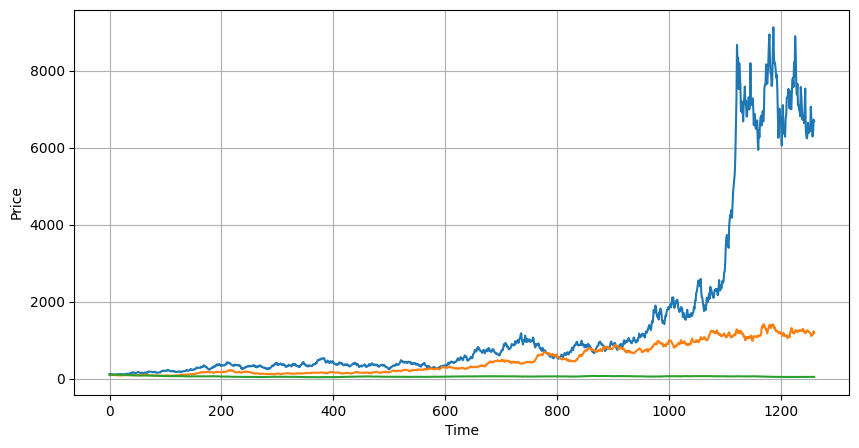

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for idi in range(3):
    ax.plot(gbm_prices[idi, :], label=f"Asset {idi+1}")
ax.grid()
ax.set_ylabel("Price")
ax.set_xlabel("Time")

## Variational AutoEncoder (VAE)

 The $\beta$-VAE used in this library has the following objective loss function:

$$
    \mathcal{L}(\theta, \phi; \bm{x}, \bm{z}, \beta) = \mathbb{E}_{q_{\phi}(\bm{z}|\bm{x})}[\log p_{\theta}(\bm{x}|\bm{z})] - \beta D_{KL}(q_{\phi}(\bm{z}|\bm{x})||p(\bm{z}))
$$

where $\theta$ and $\phi$ are the parameters of the decoder and encoder respectively, $\bm{x}$ is the input data, $\bm{z}$ is the latent space, $\beta$ is the KL divergence weight, $q_{\phi}(\bm{z}|\bm{x})$ is the encoder, $p_{\theta}(\bm{x}|\bm{z})$ is the decoder, $D_{KL}$ is the KL divergence and $p(\bm{z})$ is the prior distribution.

The code below trains a simple VAE using the `log_returns` of the above prices. 
- The Encoder uses 2 Linear layers with ReLU activations.
- The Decoder uses 3 linear layers with ReLU activations.
- Each linear layer has 150 hidden units.

In [8]:
# VAE model parameters
obs_dim = 10
code_dim = 3
vae_beta = 1e-6
num_epochs = 1000
# Initialize VAE model
vae = model_utils.VAE(obs_dim=obs_dim, code_dim=code_dim, vae_beta=vae_beta, device=device).to(device)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

train_data = torch.Tensor(np.array([calculate_log_returns(gbm_prices[0, idx:idx+100]) for idx in range(0, 1000, 100)]).T).to(device)  # slice the timeseries into 10, 100-day windows
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

def train_vae_test(vae, train_loader, optimizer, num_epochs=3):
    """
    Train the VAE model on the given dataset.
    """
    vae.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            loss, _ = vae.loss(batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Calculate and print the average loss for this epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

def test_reconstruction(vae, test_data):
    """
    Evaluate the reconstruction performance of the VAE model on the given test data.
    """
    vae.eval()
    with torch.no_grad():
        test_data = test_data.to(vae.device)
        
        mu, _, _ = vae.encode(test_data)
        reconstructed_data = vae.decoder(mu)
        
        mse_loss = F.mse_loss(test_data, reconstructed_data)
        
        print(f"Reconstruction MSE: {mse_loss.item():.4f}")
        print("\nSample comparison (original vs. reconstructed):")
        for i in range(3):
            print(f"Original: {test_data[i].cpu().numpy()}")
            print(f"Reconstructed: {reconstructed_data[i].cpu().numpy()}\n")
     
# Run the trainer test
train_vae_test(vae, train_loader, optimizer, num_epochs)
test_reconstruction(vae, train_data)


Epoch [1/1000], Loss: 0.0133
Epoch [2/1000], Loss: 0.0052
Epoch [3/1000], Loss: 0.0045
Epoch [4/1000], Loss: 0.0040
Epoch [5/1000], Loss: 0.0041
Epoch [6/1000], Loss: 0.0037
Epoch [7/1000], Loss: 0.0035
Epoch [8/1000], Loss: 0.0034
Epoch [9/1000], Loss: 0.0031
Epoch [10/1000], Loss: 0.0033
Epoch [11/1000], Loss: 0.0031
Epoch [12/1000], Loss: 0.0033
Epoch [13/1000], Loss: 0.0031
Epoch [14/1000], Loss: 0.0034
Epoch [15/1000], Loss: 0.0031
Epoch [16/1000], Loss: 0.0029
Epoch [17/1000], Loss: 0.0032
Epoch [18/1000], Loss: 0.0030
Epoch [19/1000], Loss: 0.0032
Epoch [20/1000], Loss: 0.0032
Epoch [21/1000], Loss: 0.0027
Epoch [22/1000], Loss: 0.0029
Epoch [23/1000], Loss: 0.0030
Epoch [24/1000], Loss: 0.0028
Epoch [25/1000], Loss: 0.0030
Epoch [26/1000], Loss: 0.0030
Epoch [27/1000], Loss: 0.0029
Epoch [28/1000], Loss: 0.0030
Epoch [29/1000], Loss: 0.0029
Epoch [30/1000], Loss: 0.0027
Epoch [31/1000], Loss: 0.0030
Epoch [32/1000], Loss: 0.0030
Epoch [33/1000], Loss: 0.0027
Epoch [34/1000], Lo

Text(0.5, 0, 'Time')

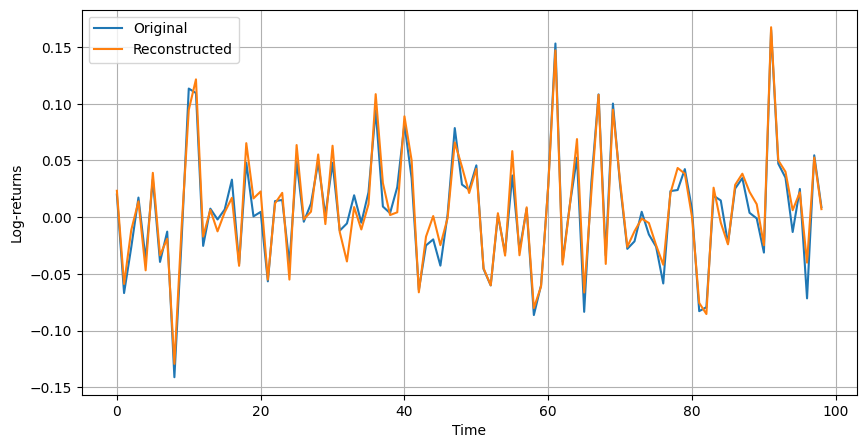

In [9]:
# Plotting the original and reconstructed log-returns
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_data.cpu().numpy()[:, 0], label="Original")
with torch.no_grad():
    reconstructed_data = vae.decoder(vae.encode(train_data)[0]).cpu().numpy()
    ax.plot(reconstructed_data[:, 0], label="Reconstructed")
ax.grid()
ax.legend()
ax.set_ylabel("Log-returns")
ax.set_xlabel("Time")

## TimeSeries VAE

The $\beta$-VAE representation is essentially over-fitting onto the time-series data and ignores the temporal dynamics of the data. To address this the `ConvVAE` model uses convolutional layers to capture the temporal dynamics of the time-series data. Instead of passing a single datapoint to the encoder, `ConvVAE` processes a sequence of data points and learns a latent representation using a [Convolutional Neural Network (CNN)](https://lilianweng.github.io/posts/2017-12-15-object-recognition-part-2/).

For time-series data, it is crucial that the VAE’s latent representation captures the temporal dynamics. Given a sequence $X = {X_{0}, X_{1}, \ldots, X_{T}}$ the model learns:

$$
    q_{\phi}(z_{t}|x_{t-k:t+k}),
$$

where $z_{t}$ is the latent representation at time $t$, and $x_{t-k:t+k}$ represents the sequence of data points from time $t - k$ to $t + k$. Here, $k$ denotes the number of time steps considered before and after time $t$. To achieve this, `ConvVAE` employs a series of convolutional layers to capture the temporal context. This approach allows the model to understand local patterns—such as trends and reversals—while maintaining temporal ordering in a compact representation.

Epoch 0: Average loss = 31.8705
Epoch 10: Average loss = 1.0369
Epoch 20: Average loss = 0.7068
Epoch 30: Average loss = 0.5888
Epoch 40: Average loss = 0.5645
Epoch 50: Average loss = 0.3624
Epoch 60: Average loss = 0.3441
Epoch 70: Average loss = 0.4287
Epoch 80: Average loss = 0.3238
Epoch 90: Average loss = 0.2933


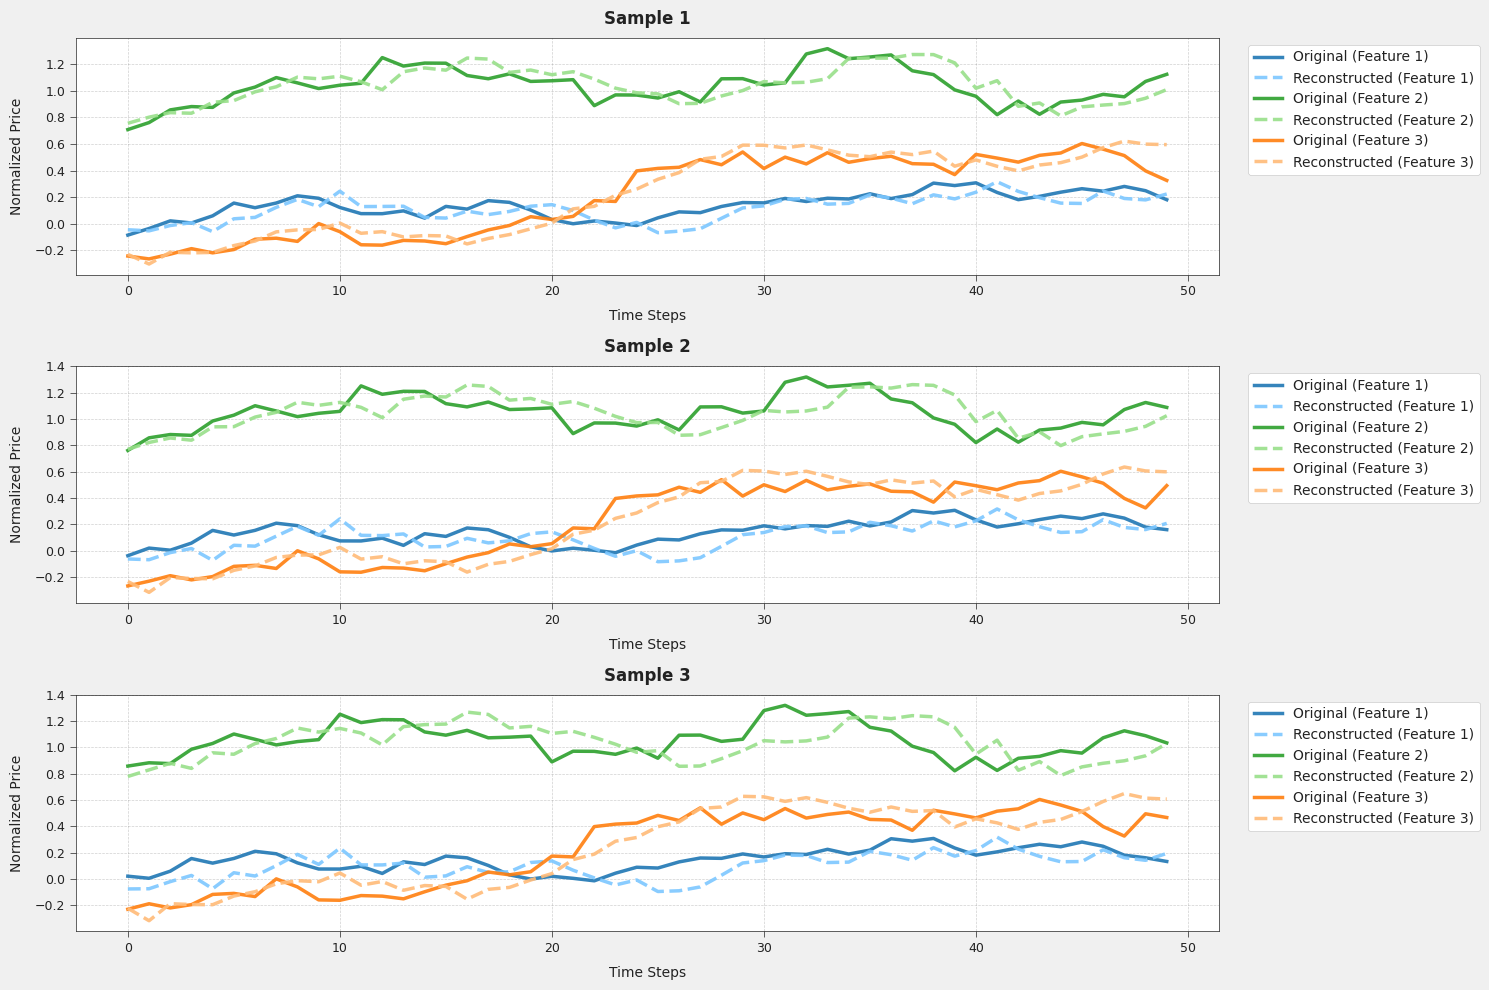

In [11]:
# Shown over the prices data

from utils.vae_training import prepare_data, train_vae, plot_reconstruction

train_loader, val_loader = prepare_data(gbm_prices, sequence_length=50, batch_size=32, train_split=0.8)
model = model_utils.ConvVAE(sequence_length=50, n_features=3, latent_dim=8, beta=1e-4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_vae(model, train_loader, optimizer, epochs=100, device=device)

plot_data = val_loader if val_loader is not None else train_loader
fig = plot_reconstruction(model, plot_data, device, n_samples=3, figsize=(15, 10))